In [1]:
import torch
import random
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
import torchvision

def datasets(d):
    def download(train):
        return d('./', download=True, train=train, transform=torchvision.transforms.ToTensor())
    return download(True), download(False)

mnist_train, mnist_test = datasets(torchvision.datasets.MNIST)
fashion_mnist_train, fashion_mnist_test = datasets(torchvision.datasets.FashionMNIST)

# Рассмотрим несколько вариантов архитектур сетей

In [4]:
class View(torch.nn.Module):
    def __init__(self, transform):
        super(View, self).__init__()
        self.transform = transform

    def forward(self, input):
        return input.view(self.transform(input))

def flatten():
    return View(lambda x: (x.size(0), -1))

In [5]:
def primitive():
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 5, 15),
        torch.nn.ReLU(),

        flatten(),

        torch.nn.Linear(5 * 14 * 14, 10)
    )

def binary_convolution():
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 5, 11),
        torch.nn.ReLU(),

        torch.nn.Conv2d(5, 20, 9),
        torch.nn.ReLU(),

        torch.nn.Conv2d(20, 20, 5),
        torch.nn.ReLU(),

        flatten(),

        torch.nn.Linear(20 * 6 * 6, 60),
        torch.nn.ReLU(),
        torch.nn.Linear(60, 10)
    )

def simplification():
    return torch.nn.Sequential(
        torch.nn.AdaptiveAvgPool2d(14),
        torch.nn.Conv2d(1, 7, 5, padding=2),
        torch.nn.ReLU(),

        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(7, 15, 2),
        torch.nn.ReLU(),

        flatten(),

        torch.nn.Linear(15 * 6 * 6, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 10)
    )

def lenet5():
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 6, 5, padding=2),
        torch.nn.ReLU(),
        torch.nn.AvgPool2d(2),

        torch.nn.Conv2d(6, 16, 5),
        torch.nn.ReLU(),
        torch.nn.AvgPool2d(2),

        flatten(),

        torch.nn.Linear(16 * 5 * 5, 120),
        torch.nn.ReLU(),
        torch.nn.Linear(120, 84),
        torch.nn.ReLU(),
        torch.nn.Linear(84, 10)
    )

In [6]:
from collections import OrderedDict

models = OrderedDict([
    ('primitive', primitive().to(device)),
    ('binary_convolution', binary_convolution().to(device)),
    ('simplification', simplification().to(device)),
    ('lenet5', lenet5().to(device))
])

# Посмотрим на результаты обучения каждой архитектуры на MNIST

In [7]:
from sklearn.metrics import accuracy_score
import tqdm

def evaluate(model, batch_size, n_epochs, train, test):
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    loader = torch.utils.data.DataLoader(train, batch_size, True, num_workers=4)
    
    x_test = test.data.unsqueeze(1).float().to(device)
    y_test = test.targets
    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []

    t = tqdm.trange(n_epochs, desc=f'Epoch 1/{n_epochs}')
    for e in t:
        epoch_loss = 0.0

        for batch in loader:
            inputs, targets = batch
            optimizer.zero_grad()
            output = model(inputs.float().to(device))
            loss = loss_function(output, targets.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data

        train_loss_history.append(epoch_loss)
        test_pred = model(x_test).cpu()
        test_loss_history.append(loss_function(
            test_pred, 
            y_test
        ).data.cpu())
        test_accuracy = accuracy_score(
            test_pred.argmax(dim=1).numpy(),
            y_test.numpy()
        )
        test_accuracy_history.append(test_accuracy)

        t.set_description(f'Epoch {e + 1}/{n_epochs}: train loss {epoch_loss}, test accuracy {test_accuracy}')
        t.refresh()
    
    return train_loss_history, test_loss_history, test_accuracy_history

In [8]:
train_losses = {}
test_losses = {}
test_accuracies = {}
epochs = 30

for name, model in models.items():
    train_losses[name], test_losses[name], test_accuracies[name] = evaluate(
        model, 100, epochs, 
        mnist_train, mnist_test
    )

Epoch 30/30: train loss 17.166364669799805, test accuracy 0.9789: 100%|██████████| 30/30 [02:38<00:00,  5.27s/it]
Epoch 30/30: train loss 6.681351184844971, test accuracy 0.9859: 100%|██████████| 30/30 [03:05<00:00,  6.18s/it]
Epoch 30/30: train loss 2.9843380451202393, test accuracy 0.9816: 100%|██████████| 30/30 [02:57<00:00,  5.91s/it]
Epoch 30/30: train loss 3.720590353012085, test accuracy 0.9862: 100%|██████████| 30/30 [03:06<00:00,  6.21s/it]


In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
def plot_stat(model_names):
    colors = ['b', 'r', 'g', 'y']
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    for i, ylabel in enumerate(['log train loss', 'test loss', 'accuracy']):
        ax[i].set_xlabel('epoch')
        ax[i].set_ylabel(ylabel)
    for i, name in enumerate(model_names):
        ax[0].plot(np.log(train_losses[name]), c=colors[i], label=name)
        ax[1].plot(test_losses[name], c=colors[i], label=name)
        ax[2].plot(test_accuracies[name], c=colors[i], label=name)
    for i in range(3):
        ax[i].legend()

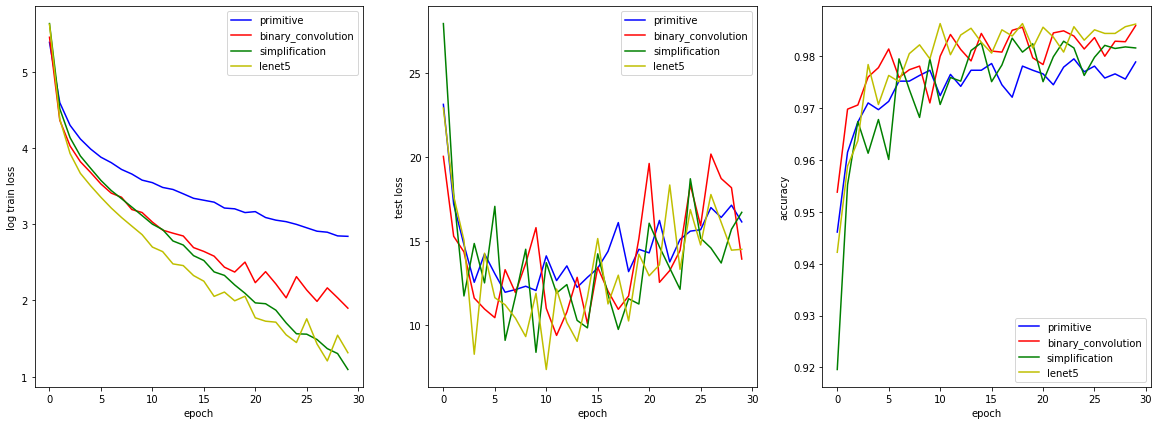

In [11]:
plot_stat(models.keys())

Поскольку `lenet5` показал себя лучше всех остальных, возьмем его для дальнейшего использования



In [12]:
model = lenet5().to(device)
evaluate(model, 100, epochs, mnist_train, mnist_test)

Epoch 30/30: train loss 3.404191255569458, test accuracy 0.9895: 100%|██████████| 30/30 [03:06<00:00,  6.22s/it]


([tensor(272.0101, device='cuda:0'),
  tensor(76.4481, device='cuda:0'),
  tensor(48.0911, device='cuda:0'),
  tensor(37.5177, device='cuda:0'),
  tensor(29.8738, device='cuda:0'),
  tensor(26.3558, device='cuda:0'),
  tensor(21.4926, device='cuda:0'),
  tensor(19.4847, device='cuda:0'),
  tensor(17.2222, device='cuda:0'),
  tensor(15.0649, device='cuda:0'),
  tensor(13.0824, device='cuda:0'),
  tensor(12.1491, device='cuda:0'),
  tensor(10.1495, device='cuda:0'),
  tensor(9.2487, device='cuda:0'),
  tensor(8.7425, device='cuda:0'),
  tensor(7.6378, device='cuda:0'),
  tensor(7.2131, device='cuda:0'),
  tensor(6.6361, device='cuda:0'),
  tensor(6.4276, device='cuda:0'),
  tensor(5.2666, device='cuda:0'),
  tensor(4.7453, device='cuda:0'),
  tensor(5.3742, device='cuda:0'),
  tensor(4.0682, device='cuda:0'),
  tensor(4.0607, device='cuda:0'),
  tensor(5.0209, device='cuda:0'),
  tensor(3.3165, device='cuda:0'),
  tensor(3.2843, device='cuda:0'),
  tensor(3.0712, device='cuda:0'),
  tens

In [13]:
from sklearn.metrics import confusion_matrix as cm

def confusion_matrix(model, test, figsize=(10, 10)):
    x_test = test.data.unsqueeze(1).float().to(device)
    y_test = test.targets
    y_pred = model(x_test).cpu()
    y_pred_classes = y_pred.argmax(dim=1).numpy()
    
    print(cm(y_test.numpy(), y_pred_classes))
    cls = y_pred.size(1)
    fig, ax = plt.subplots(cls, cls, figsize=figsize)
    max_scores = [[(float('-inf'), None) for _ in range(cls)] for _ in range(cls)]
    for i in range(len(y_test)):
        c = y_test[i]
        for j in range(cls):
            if max_scores[c][j][0] < y_pred[i, j]:
                max_scores[c][j] = (y_pred[i, j], i)
    
    for i in range(cls):
        for j in range(cls):
            idx = max_scores[i][j][1]
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            if idx is not None:
                ax[i, j].imshow(test.data[idx, :, :])
                if y_pred_classes[idx] == j:
                    ax[i, j].patch.set_edgecolor('red')  
                    ax[i, j].patch.set_linewidth('5')

[[ 979    0    0    0    0    0    0    0    0    1]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   2    0 1023    1    1    0    0    5    0    0]
 [   0    0    1 1006    0    3    0    0    0    0]
 [   0    0    0    0  976    0    3    1    0    2]
 [   2    0    0    9    0  880    1    0    0    0]
 [   3    3    1    0    2    5  943    0    1    0]
 [   0    2    2    0    1    0    0 1022    1    0]
 [   3    0    2    4    5    6    0    5  946    3]
 [   0    3    0    4    9    4    0    3    1  985]]


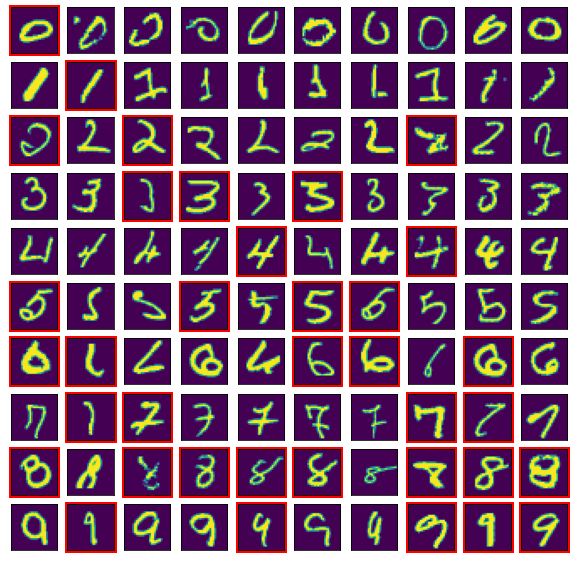

In [14]:
confusion_matrix(model, mnist_test)

# Построим все то же самое для FashionMNIST

In [ ]:
def init_random():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True

init_random()

model = lenet5().to(device)
name = 'lenet5-fashion'
train_losses[name], test_losses[name], test_accuracies[name] = evaluate(model, 100, epochs, fashion_mnist_train, fashion_mnist_test)

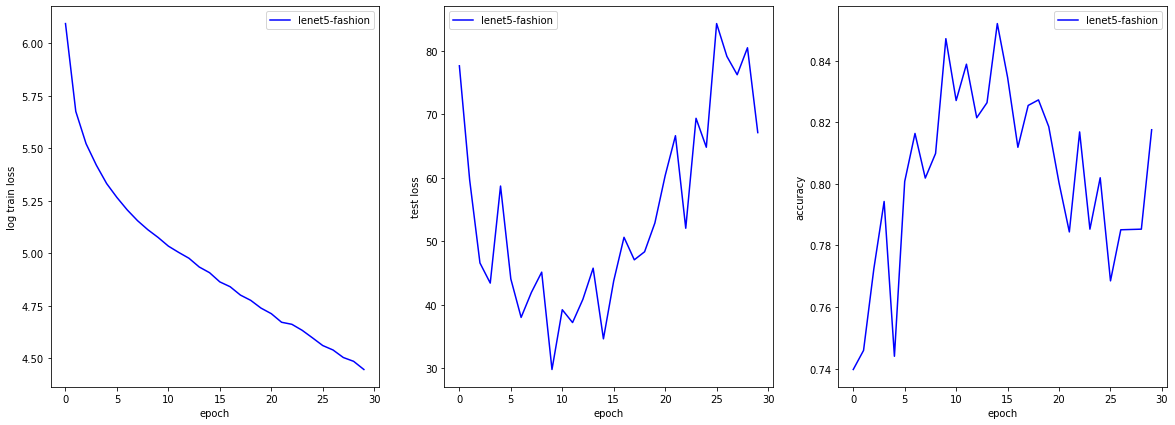

In [25]:
plot_stat(['lenet5-fashion'])

Как видно, наилучший результат достигается на 14 эпохах, и дальше играет роль переобучение

In [ ]:
init_random()
model = lenet5().to(device)
evaluate(model, 100, 14, fashion_mnist_train, fashion_mnist_test)

[[4842  115  167  130  212   31  207    4  282   10]
 [   1 5977    3    7    5    0    1    0    5    1]
 [  96    9 3413   10 2079    6  266    0  106   15]
 [ 708  459   30 3812  550  124   70    1  179   67]
 [   2   19   52   59 5808    0   19    0   39    2]
 [  63   42   33    0    7 5440   31   11  371    2]
 [ 864  107  172   77 2457   15 2053    0  248    7]
 [  83   18    9   33   13 2199    8 3057  331  249]
 [  27   15   10    3   41   12   24    1 5856   11]
 [  20    3    1    3    0  766    3  114   42 5048]]


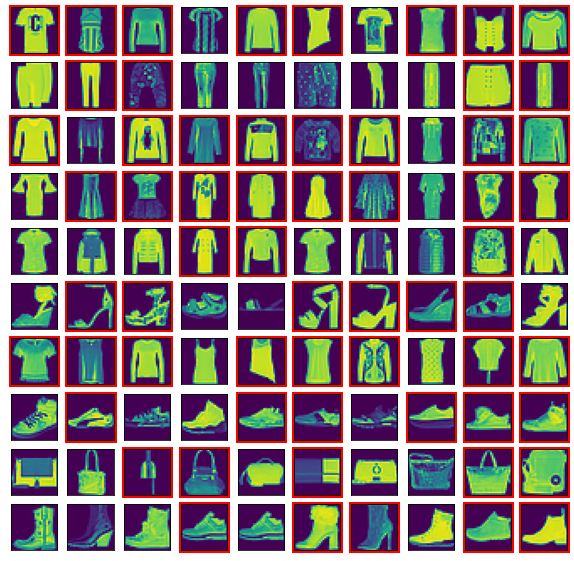

In [18]:
confusion_matrix(model, fashion_mnist_train)

In [28]:
print(test_accuracies['lenet5-fashion'][14])

0.8521
